In [1]:
import pandas as pd
import numpy as np


In [2]:
holidays = pd.read_csv('favorita-grocery-sales-forecasting/holidays_events.csv')
chosen_df = pd.read_csv('chosen_df.csv')

In [3]:
chosen_df

,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,dcoilwtico,city,state,type,cluster,year,month,day
0,2016-01-02,1,114790,7.0,0,12,1004,0,False,0,0,3,13,2016,1,2
1,2016-01-02,1,215331,8.0,0,12,1040,0,False,0,0,3,13,2016,1,2
2,2016-01-02,1,222879,6.0,0,12,1058,0,False,0,0,3,13,2016,1,2
3,2016-01-02,1,261052,6.0,0,12,1072,0,False,0,0,3,13,2016,1,2
4,2016-01-02,1,261053,3.0,0,12,1072,0,False,0,0,3,13,2016,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208353,2017-08-15,49,1036689,48.0,0,12,1040,0,47.57,0,0,0,11,2017,8,15
208354,2017-08-15,49,1146795,47.0,1,12,1040,0,47.57,0,0,0,11,2017,8,15
208355,2017-08-15,49,1159414,22.0,0,12,1040,0,47.57,0,0,0,11,2017,8,15
208356,2017-08-15,49,1162382,17.0,0,12,1022,0,47.57,0,0,0,11,2017,8,15


In [4]:
chosen_df['dcoilwtico'].isna().sum()

0

In [5]:
chosen_df['dcoilwtico'].value_counts()

dcoilwtico
False    59452
49.1      1075
52.36     1072
46.73     1068
45.11     1066
         ...  
44.36      336
46.81      336
44.66      336
45.32      335
48.67      335
Name: count, Length: 362, dtype: int64

In [6]:
chosen_df["dcoilwtico"] = pd.to_numeric(chosen_df["dcoilwtico"], errors='coerce')

In [ ]:
holidays = holidays[['date','type']]
holidays.rename(columns={'type':"holiday_type"},inplace=True)

In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
holidays['holiday_type_encoded'] = label_encoder.fit_transform(holidays['holiday_type'])

In [9]:
dict(enumerate(label_encoder.classes_))


{0: 'Additional',
 1: 'Bridge',
 2: 'Event',
 3: 'Holiday',
 4: 'Transfer',
 5: 'Work Day'}

In [10]:
chosen_df = chosen_df.merge(holidays,on='date',how='left')

In [11]:
chosen_df["is_holiday"] = chosen_df["holiday_type"].notna()


In [12]:
chosen_df["holiday_type"].fillna(False, inplace=True)


/var/folders/9z/jhl761ys4zxdmlymdmcfs3jm0000gn/T/ipykernel_36562/3560963026.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chosen_df["holiday_type"].fillna(False, inplace=True)


In [13]:
chosen_df['holiday_type'].value_counts()


holiday_type
False         173725
Holiday        20081
Event          12402
Additional      4290
Transfer        2500
Bridge           339
Work Day         337
Name: count, dtype: int64

In [14]:
chosen_df['holiday_type_encoded'].fillna(6, inplace=True)

/var/folders/9z/jhl761ys4zxdmlymdmcfs3jm0000gn/T/ipykernel_36562/1620878766.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chosen_df['holiday_type_encoded'].fillna(6, inplace=True)


In [15]:
chosen_df['unit_sales'].max(),chosen_df['unit_sales'].min()

(12228.0, -1797.0)

<Axes: >

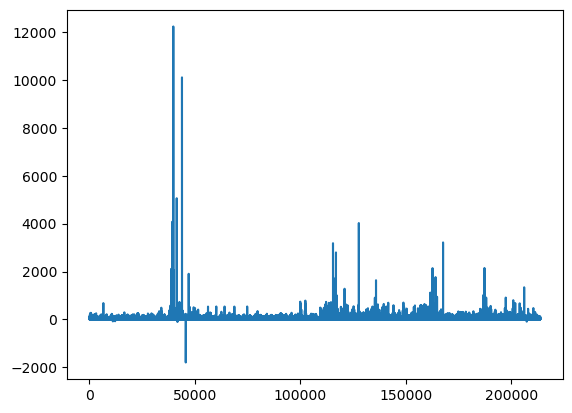

In [16]:
chosen_df['unit_sales'].plot()

In [17]:
chosen_df = chosen_df.sort_values(by=["store_nbr", "item_nbr", "date"])

# Create lagged features (1-day and 7-day unit sales)
chosen_df["lag_1"] = chosen_df.groupby(["store_nbr", "item_nbr"])["unit_sales"].shift(1)
chosen_df["lag_7"] = chosen_df.groupby(["store_nbr", "item_nbr"])["unit_sales"].shift(7)

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
chosen_df['unit_sales'] = scaler.fit_transform(chosen_df[['unit_sales']])

In [24]:
x = chosen_df[['store_nbr','item_nbr','onpromotion','class','dcoilwtico','perishable','type','cluster','month','day','is_holiday','holiday_type_encoded']]
y= chosen_df['unit_sales']

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [26]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()


In [27]:
model.fit(x_train,y_train)

RandomForestRegressor()

In [28]:
predictions = model.predict(x_test)

In [22]:
predictions

array([0.12839453, 0.13060606, 0.13366774, ..., 0.13366631, 0.12886272,
       0.12875009])

In [23]:
y_test.values



array([0.12819964, 0.13083779, 0.13269162, ..., 0.13219251, 0.12877005,
       0.12941176])

In [33]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mae = mean_absolute_error(scaler.inverse_transform([y_test.values]), scaler.inverse_transform([predictions]))
mse = mean_squared_error(scaler.inverse_transform([y_test.values]), scaler.inverse_transform([predictions]))
r2 = r2_score(y_test.values, predictions)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 9.945488724930815
Mean Squared Error: 1604.5078495112623
R-squared: 0.6800226541001524


In [35]:
scaler.inverse_transform([y_test.values]).flatten()

array([ 1., 38., 64., ..., 57.,  9., 18.])

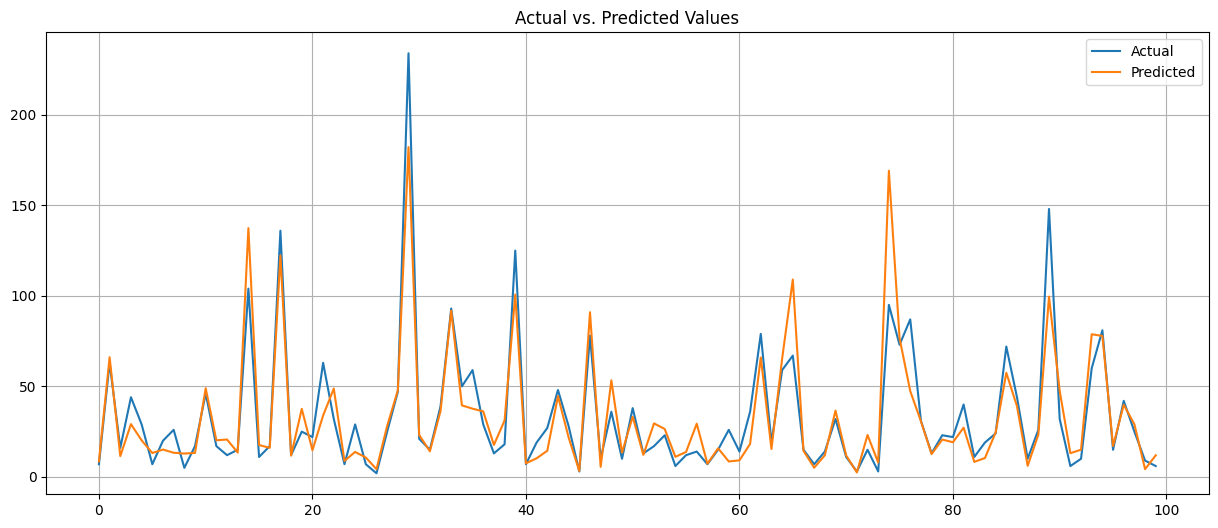

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform([y_test.values]).flatten()[1000:1100],label='Actual')
plt.plot(scaler.inverse_transform([predictions]).flatten()[1000:1100],label='Predicted')
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.grid(True)
plt.show()